# Law, Order, and Algorithms

## Estimating the prevalence and placement of surveillance cameras

In [1]:
library(tidyverse)
library(ggmap) 
# shouldn't need to add an API key as the relevant map is pre-saved

theme_set(theme_bw(base_size = 14))
options(digits = 3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.


In this lab, we'll work to replicate the results from [Sheng et al. (2021)](https://5harad.com/papers/surveilling-surveillance.pdf), where the authors estimate the prevalence of surveillance cameras across the United States using Google street view data.

Specifically, we will perform two tasks in this lab:
1. Estimate the density of surveillance cameras in San Francisco;
2. Examine the relationship between camera placement and the demographic composition of a neighborhood.

### Data

In [2]:
# Load data
load(file = "../data/surveillance_sf.RData")

We are loading four objects into the notebook. They are:

#### cameras_sf
(one row per image)
- `panoid`: ID of image 
- `lat-lon`: coordinates of image
- `period`: year of image
- `detected`, `verified`: whether a (verified) camera is in the image, explained below

#### census_sf
(one row per census block-group)
- `GEOID`, `NAME`: ID and name of census block group (CBG)
- `total_pop`: total population of CBG
- `total_white`: total non-Hispanic white population of CBG
- `geometry`: multipolygon shape of census block group

#### cameras_all
(one row per image, covering 10 U.S. cities)
- `panoid`: ID of image 
- `city`: city of image
- `period`: year of image
- `verified`: indicator for whether the image contains a verified camera
- `zone_type`: the designation of the area (e.g., `Residential` or `Commercial`) 
- `percentage_minority`: demographic composition of the CBG where the image was taken
- census_block_group: the CBG of the image

#### ggmap_sf
- saved map of San Francisco

In [3]:
head(cameras_sf)

panoid,lat,lon,period,detected,verified
<chr>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
00IKbj1qYdDAYuCmzV91Cg,37.8,-122,2016-2020,FALSE,FALSE
01-m6VHH8NCAZ9lCxGOyRw,37.7,-122,2016-2020,FALSE,FALSE
02J2lVjjVjFxXs5MIF6bAQ,37.8,-122,2016-2020,FALSE,FALSE
038rjTmcixsbfpGHIn8Kxw,37.8,-122,2016-2020,FALSE,FALSE
03xdkUAKkEWKoTsS-5OWBg,37.8,-122,2016-2020,FALSE,FALSE
04B-UXmWo4hnYqghzN8fuQ,37.7,-122,2016-2020,FALSE,FALSE


### Object detection models

In order to identify cameras using street view images, we will use an [object detection](https://en.wikipedia.org/wiki/Object_detection) model.
An object detection model is a computer vision model that detects instances of objects of a certain class within an image.
In this particular case we are interested in detecting cameras in an image, but in practice such models can be used to detect all kinds of objects.

While object detection model performance has increased drastically due in large part to the rise of deep learning, enabling a number of previously impossible applications, they are not perfect models.
In order to understand how well the camera detection model works, we evaluate it using two useful metrics: [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

In our camera detection application, the existance of a camera is considered to be "positive".
Given a dataset of camera detection predictions produced by our object detection model and the corresponding ground truth labels verified by humans, we can define the following terms:

* P: the number of real positive cases in the data
* N: the number of real negative cases in the data
* TP: true positives; the number of predicted positive cases that were real positives 
* TN: true negatives; the number of predicted negative cases that were real negatives 
* FP: false positives; the number of predicted positives that were actually negative in the data (false alarms, Type I error)
* FN: false negatives; the number of predicted negatives that were actually positive in the data (Type II error) 

Their definitions can be illustrated using following table:

<br>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0; margin: auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#BBBBBB;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#BBBBBB;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-baqh">Real positive</th>
    <th class="tg-baqh">Real negative</th>
  </tr>
  <tr>
    <td class="tg-baqh">Predicted positive</td>
    <td class="tg-baqh">TP</td>
    <td class="tg-baqh">FP</td>
  </tr>
  <tr>
    <td class="tg-baqh">Predicted negative</td>
    <td class="tg-baqh">FN</td>
    <td class="tg-baqh">TN</td>
  </tr>
</table>
<br>


Precision is defined as
$\frac{TP}{TP + FP} = \frac{N_{\text{correctly identified cameras}}}{N_{\text{identified cameras}}}$

Recall is defined as
$\frac{TP}{TP + FN} = \frac{N_{\text{correctly identified cameras}}}{N_{\text{real cameras}}}$


This diagram from Wikipedia visually illustrates these definitions:

![Precision and recall](../images/precision_recall.png)


#### Exercise: calculate model precision
We previously trained a camera detection model, which we then applied to a sample of Google street view images. Afterwards, human annotators reviewed each of the images in which a camera was `detected` by the model and `verified` whether a camera was actually there.
Now, as an exercise, let's calculate the precision of our model using the columns `verified` and `detected` from the data frame `cameras_sf`. 

In [4]:
# Your code here!
# START solution
cameras_sf %>%
  summarize(precision = sum(verified) / sum(detected))
# END solution

precision
<dbl>
0.426


### Estimating the prevalence of surveillance cameras in San Francisco

As we see above, the model's performance is far from perfect.
However, we are still able to use this model to help us estimate the number of cameras in SF.

By running the camera detection model on a random sample of street view images (in `cameras_sf`), we can estimate the total number of cameras in SF using three ingredients:

1. The number of verified cameras in this sample
1. The percentage of all roads in SF covered by the sample
1. The model's recall

By running the camera detection model on a random sample of positive instances (i.e., images with cameras), we estimate the model's recall is 0.67. (Discuss: why is this more laborious than calculating precision?)
Now let's carry out steps 1 and 2.

#### Exercise: calculate the number of verified cameras in our SF sample

In [5]:
# Calculate the number of verified cameras: n_verified
# Your code here!
# START solution
n_verified <- sum(cameras_sf$verified)
# END solution
n_verified

[1] 40

#### Exercise: calculate the fraction of roadway in SF covered by the sample

In [6]:
# Constants
# Total road length in San Francisco (in meters)
road_length_m <- 3108000
# Average length of road covered by one image in the dataset (in meters)
avg_image_length_m <- 24.1

# Calculate percentage of all roads in SF covered by the sample: perc_road_covered
# Your code here!
# START solution
n_images <- nrow(cameras_sf)
frac_road_covered <- avg_image_length_m * n_images / (road_length_m)
# END solution

frac_road_covered

[1] 0.0388

Now we are able to estimate the total number of cameras in SF visible from the road.
#### Exercise: derive a formula to estimate the number of cameras in SF

Keep in mind that every street view image covers only one side of a two-sided street.

In [7]:
# Constants
# Recall of the camera detection model
recall <- 0.67

# Estimate camera detections and density
# Your code here!
# START solution
est_cameras <- 2 * n_verified * (1 / recall) * (1 / frac_road_covered)
# END solution

est_cameras

[1] 3080

Finally, we can calculate the camera density as follows:

In [8]:
est_cameras_per_km <- est_cameras / (road_length_m / 1000)
est_cameras_per_km

[1] 0.991

### Plotting the location of camera detections
We can plot the locations of detected cameras in our sample on a map to help us better understand their spatial distribution. What patterns do you notice in the placement of cameras?

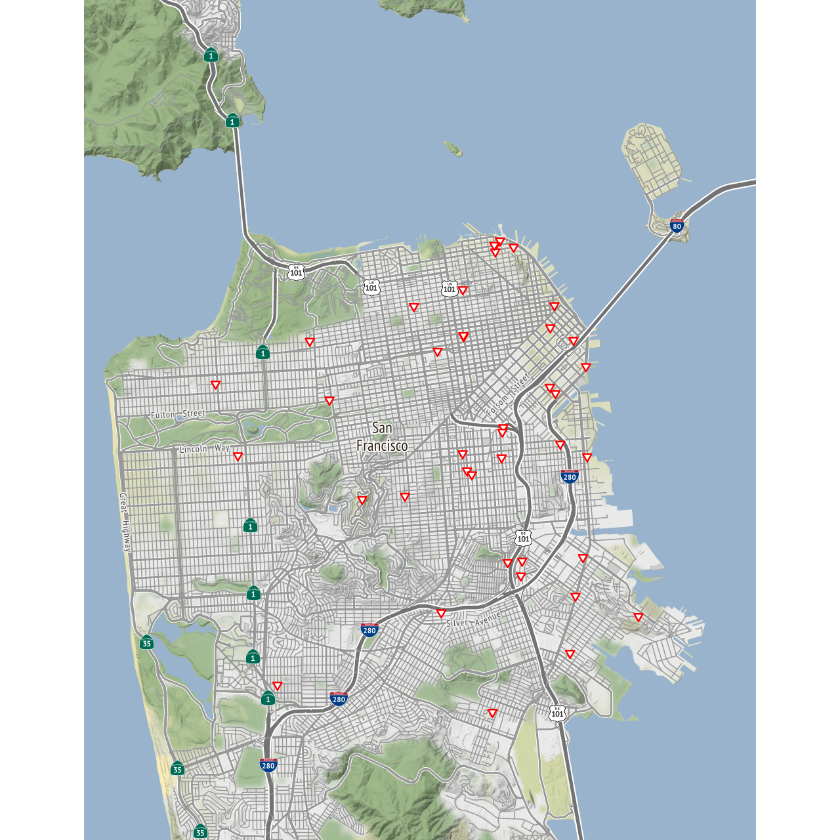

In [9]:
ggmap(ggmap_sf, extent = "device") +
  geom_point(data = cameras_sf %>% 
               filter(verified),
             aes(x = lon, y = lat),
             position = "jitter", 
             shape = 25, fill = "white", color = "red",
             alpha = 1, size = 1.5) +
  theme(axis.text = element_blank(), 
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank())

### Racial disparities in camera placement
By performing the analysis above for multiple cities across the U.S. and combining the results with census data,
we can examine the relationship between camera density and share of minorities (defined as those who identify as either Hispanic or non-white) in that location.

Discuss: what do we see here? What might be driving the results?

Warning message:
“Removed 712 rows containing non-finite values (stat_smooth).”

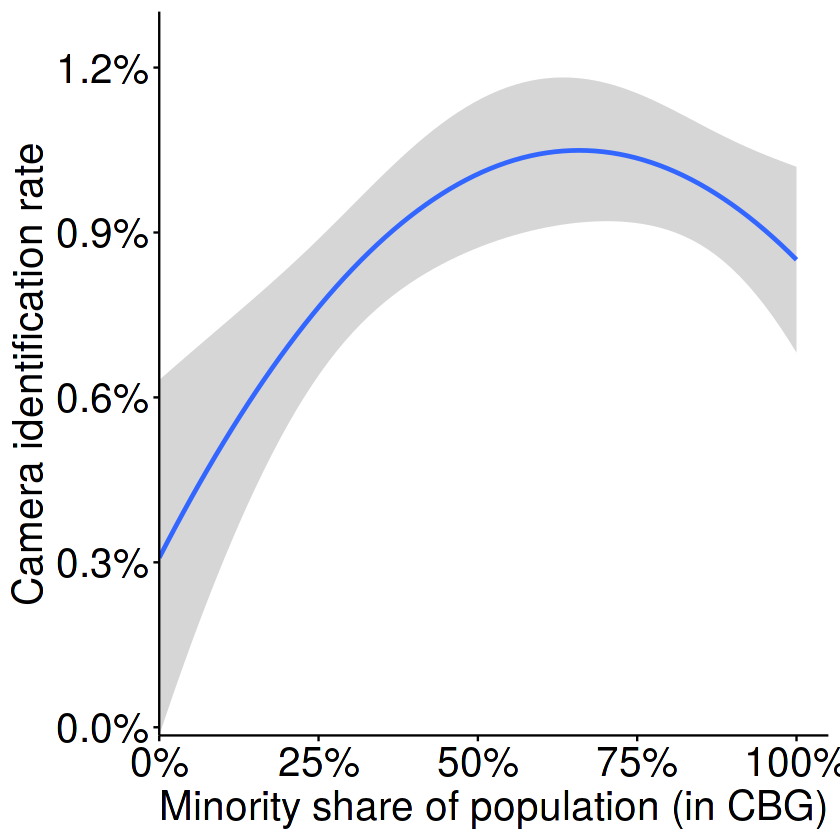

In [10]:
cameras_all %>%
  ggplot(aes(x = percentage_minority, y = verified)) +
  #geom_hline(yintercept = avg_detection_rate, linetype = "dashed", color = "gray") + # avg detection rate
  geom_smooth(method = "lm", 
              formula = y ~ poly(x, degree = 2),
              se = T) +
  scale_x_continuous(
    name = "Minority share of population (in CBG)", 
    #breaks = seq(0, 1, 0.1),
    expand = expansion(mult = c(0, 0.05)),
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_y_continuous(
    name = "Camera identification rate",  
    breaks = seq(0, 0.012, 0.003),
    expand = expansion(mult = c(0, 0.1)),
    labels = scales::percent_format(accuracy = 0.1)
  ) +
  theme(
    panel.grid = element_blank(),
    panel.border = element_blank(),
    axis.text = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.title = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.line = element_line(size = 0.5, color = "black"),
    axis.ticks.x = element_line(size = 0.5, color = "black"),
    axis.ticks.y = element_line(size = 0.5, color = "black")
  ) 